In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, ConcatDataset, random_split
from torch.utils.data.sampler import WeightedRandomSampler

from dataset import TextDataset    # <------- Replace with your datasets
from fastprogress import master_bar, progress_bar

# Dataset

In [2]:
class PadSequence:
    def __init__(self, pad_value=-1):
        self.pad_value = pad_value
    
    def _pad_sequence(self, seq):
        seq_padded = pad_sequence(
            seq, 
            batch_first=True, 
            padding_value=self.pad_value
        )
        return seq_padded
        
    def __call__(self, batch):
        transposed = list(map(list, zip(*batch)))
        padded = []
        for items in transposed:
            padded.append(self._pad_sequence(items))
        return tuple(padded)

    
    
# Datasets: replace with your own datasets, __getitem__ should output (B, L, D) shape tensor
# where B is batch size, L is the sequence length, D is the number of aminoacid types
dataset = ConcatDataset([
    TextDataset("data/ncbi/spike_protein_non_human_host.txt", label=torch.tensor([0]), onehot=True),
    TextDataset("data/ncbi/spike_protein_human_host.txt", label=torch.tensor([1]), onehot=True)
])

# split dataset
train_ratio = 0.8
generator = torch.Generator().manual_seed(42)
train_set, test_set = random_split(
    dataset, 
    [train_ratio, 1 - train_ratio], 
    generator=generator
)

# define the class weights: here in data 80% are the first class and 20% are the second class
class_weights = torch.FloatTensor([0.8 if i == 0 else 0.2 for _, i in train_set])

# create the class-balanced sampler
sampler = WeightedRandomSampler(
    weights=class_weights,
    num_samples=len(train_set),
    replacement=True
)

# data loader
train_loader = DataLoader(
    train_set, 
    batch_size=40, 
    collate_fn=PadSequence(-1),
    sampler=sampler,
)
test_loader = DataLoader(
    test_set, 
    batch_size=100, 
    collate_fn=PadSequence(-1), 
    shuffle=False,
)

# Multi-head Attention SVM

In [3]:
import numpy as np
import torch
import torch.nn as nn


def get_emb(sin_inp):
    """
    Gets a base embedding for one dimension with sin and cos intertwined
    """
    emb = torch.stack((sin_inp.sin(), sin_inp.cos()), dim=-1)
    return torch.flatten(emb, -2, -1)


#  -------------- Transformer-SVM Model -------------- 
class PositionalEncoding1D(nn.Module):
    def __init__(self, channels):
        """
        :param channels: The last dimension of the tensor you want to apply pos emb to.
        """
        super(PositionalEncoding1D, self).__init__()
        self.org_channels = channels
        channels = int(np.ceil(channels / 2) * 2)
        self.channels = channels
        inv_freq = 1.0 / (10000 ** (torch.arange(0, channels, 2).float() / channels))
        self.register_buffer("inv_freq", inv_freq)
        self.cached_penc = None

    def forward(self, tensor):
        """
        :param tensor: A 3d tensor of size (batch_size, x, ch)
        :return: Positional Encoding Matrix of size (batch_size, x, ch)
        """
        if len(tensor.shape) != 3:
            raise RuntimeError("The input tensor has to be 3d!")

        if self.cached_penc is not None and self.cached_penc.shape == tensor.shape:
            return self.cached_penc

        self.cached_penc = None
        batch_size, x, orig_ch = tensor.shape
        pos_x = torch.arange(x, device=tensor.device).type(self.inv_freq.type())
        sin_inp_x = torch.einsum("i,j->ij", pos_x, self.inv_freq)
        emb_x = get_emb(sin_inp_x)
        emb = torch.zeros((x, self.channels), device=tensor.device).type(tensor.type())
        emb[:, : self.channels] = emb_x

        self.cached_penc = emb[None, :, :orig_ch].repeat(batch_size, 1, 1)
        return self.cached_penc
    

class TransformerSVM(nn.Module):
    def __init__(self, input_dim=26, d_model=128, dropout=0.0):
        super(TransformerSVM, self).__init__()
        self.embedding = nn.Conv1d(input_dim, d_model, kernel_size=16, stride=16, padding=8)
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=16,
            norm_first=True,
            batch_first=True,
            dim_feedforward=d_model*2,
            num_encoder_layers=2, 
            num_decoder_layers=2,
            dropout=dropout,
            activation="gelu",
        )
        self.target = nn.Parameter(torch.randn(d_model) * 0.02, requires_grad=True)
        self.linear = nn.Linear(d_model, 1)
        self.pos_enc = PositionalEncoding1D(d_model)
        
    def forward(self, x):
        x = torch.einsum("bld->bdl", x)
        x = self.embedding(x.float())
        x = torch.einsum("bdl->bld", x)
        x = x + self.pos_enc(x)
        target = self.target.repeat(len(x), 1, 1)
        x = self.transformer(src=x, tgt=target)
        return self.linear(x)
    
    

# -------------- ResNet-SVM Model -------------- 
class LayerNorm(nn.LayerNorm):
    def forward(self, x):
        x = torch.einsum("bld->bdl", x)
        x = super().forward(x)
        x = torch.einsum("bdl->bld", x)
        return x
    
    
class ResNetSVM(nn.Module):
    def __init__(self, input_dim=26, d_model=128, dropout=0.0, num_blocks=8):
        super(ResNetSVM, self).__init__()
        self.embedding = nn.Conv1d(input_dim, d_model, kernel_size=5, stride=1, padding=2)
        self.blocks = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(d_model, d_model, kernel_size=4, stride=2, padding=1),
                nn.ReLU(),
                LayerNorm(d_model),
                nn.Conv1d(d_model, d_model, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                LayerNorm(d_model),
            ) for _ in range(num_blocks)
        ])
        self.linear = nn.Linear(d_model, 1)
        
    def forward(self, x):
        x = torch.einsum("bld->bdl", x)
        x = self.embedding(x)
        
        # forward all the blocks
        for blk in self.blocks:
            out = blk(x)
            x = out + F.adaptive_max_pool1d(x, out.shape[-1])
            
        # global pooling
        x = F.adaptive_avg_pool1d(x, 1)
        x = torch.einsum("bdl->bld", x)
        return self.linear(x)
    
    
device = torch.device("cuda:1")
model = TransformerSVM(
    input_dim=26,
    d_model=512, 
    dropout=0.0,
).to(device)

# Optimizers

In [4]:
num_epochs = 1000
criterion = nn.MarginRankingLoss(margin=1.0)

# use lr=1e-3 (also max_lr) for ResNet and lr=2e-4 (also max_lr) for Transformer
optimizer = optim.Adam(model.parameters(), lr=2e-4, weight_decay=0.000)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=2e-4, total_steps=num_epochs, div_factor=100, 
    pct_start=0.05, anneal_strategy='cos', final_div_factor=10000.0,
)

# Training Loop

In [5]:
model.train()
mb = master_bar(range(num_epochs))
pb = progress_bar(train_loader, parent=mb)
for epoch in mb:
    losses = []
    for inputs, labels in pb:
        optimizer.zero_grad()
        outputs = model(inputs.to(device)).squeeze()
        labels = 2 * labels.squeeze() - 1     # Convert labels to 1/-1
        loss = criterion(outputs, -outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        
        losses.append(loss.detach())
    scheduler.step()
    loss = sum(losses) / len(losses)
    if epoch % 1 == 0:
        print(epoch, 'Train Loss: {:.6f}'.format(loss.item()))

0 Train Loss: 0.910477
1 Train Loss: 0.962012
2 Train Loss: 0.924949
3 Train Loss: 0.925409
4 Train Loss: 0.897260
5 Train Loss: 0.867577
6 Train Loss: 0.874651
7 Train Loss: 0.878793
8 Train Loss: 0.858500
9 Train Loss: 0.857892
10 Train Loss: 0.856273
11 Train Loss: 0.838902
12 Train Loss: 0.831877
13 Train Loss: 0.818408
14 Train Loss: 0.749663
15 Train Loss: 0.749030
16 Train Loss: 0.744048
17 Train Loss: 0.750389
18 Train Loss: 0.707430
19 Train Loss: 0.745775
20 Train Loss: 0.748236
21 Train Loss: 0.730816
22 Train Loss: 0.738784
23 Train Loss: 0.745727
24 Train Loss: 0.710819
25 Train Loss: 0.705997
26 Train Loss: 0.719336
27 Train Loss: 0.698750
28 Train Loss: 0.759701
29 Train Loss: 0.732248
30 Train Loss: 0.730717
31 Train Loss: 0.706834
32 Train Loss: 0.699793
33 Train Loss: 0.697940
34 Train Loss: 0.714483
35 Train Loss: 0.694205
36 Train Loss: 0.754423
37 Train Loss: 0.699124
38 Train Loss: 0.775063
39 Train Loss: 0.777758
40 Train Loss: 0.705936
41 Train Loss: 0.694321
42

# Evaluate Train

In [7]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in progress_bar(train_loader):
        outputs = model(inputs.to(device)).squeeze()
        predicted = (torch.sign(outputs) + 1) / 2     # Convert back to 0/1
        total += labels.size(0)
        correct += (predicted == labels.to(device).squeeze()).sum().item()

accuracy = 100 * correct / total
print('Test accuracy: {:.2f}%'.format(accuracy))

Test accuracy: 67.24%


# Evaluate Test

In [51]:
model.eval()
correct = 0
total = 0

test_labels = []
test_inputs = []
test_outputs = []
with torch.no_grad():
    for inputs, labels in progress_bar(test_loader):
        outputs = model(inputs.to(device)).squeeze()
        predicted = (torch.sign(outputs) + 1) / 2  # Convert back to 0/1
        total += labels.size(0)
        correct += (predicted == labels.to(device).squeeze()).sum().item()
        
        labels = labels.squeeze()
        
        # unpad inputs
        inputs = [i[(i != -1).any(-1)] for i in inputs]
        
        test_inputs.extend(inputs)
        test_labels.append(labels)
        test_outputs.append(outputs)

test_outputs = torch.cat(test_outputs, dim=0).cpu().numpy()
test_labels = torch.cat(test_labels, dim=0).cpu().numpy()

accuracy = 100 * correct / total
print('Test accuracy: {:.2f}%'.format(accuracy))

Test accuracy: 82.52%


# Visualization

In [52]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

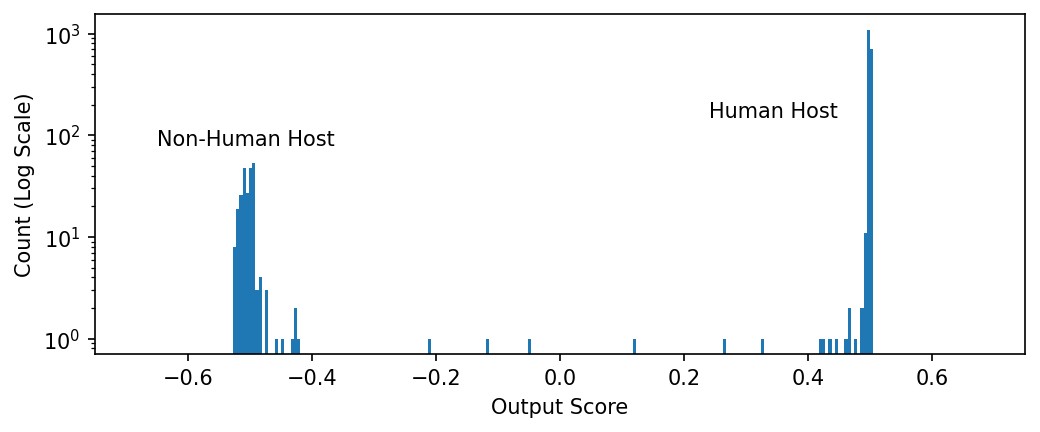

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3), dpi=150)
ax.hist(test_outputs, bins=200)
ax.set_yscale("log")
ax.set_xlabel("Output Score")
ax.set_ylabel("Count (Log Scale)")
ax.text(0.24, 150, "Human Host")
ax.text(-0.65, 80, "Non-Human Host")
ax.set_xlim(-0.75, 0.75)
plt.show()

## Get Support Vectors

In [57]:
sv_margin = 0.4
sv_masks = np.absolute(test_outputs) < sv_margin
sv_idx = list(np.where(sv_masks)[0])
sv_scores = test_outputs[sv_masks]
support_vectors = [test_inputs[i] for i in sv_idx]
sv_scores

array([-0.11891922,  0.12089213, -0.20900056, -0.05192478,  0.32615563,
        0.26391616], dtype=float32)